In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
res1 = pd.read_csv('../results/runs/052623/results_xgb_folfox_OS_comb_052623.csv', index_col=0)
res1.head()

,fold,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,0,0.777612,0.6854916816503743-0.8697315239657742,0.794643,0.7703711113951469-0.8189146028905675,0.765503,0.740046726252081-0.7909601071737741
1,1,0.770019,0.7175307734505394-0.8225067433061828,0.802474,0.778552166683152-0.8263951248313036,0.800918,0.7769262311621081-0.8249106008939149
2,2,0.786206,0.7015926265171472-0.8708203218620177,0.796263,0.7720630132534749-0.8204638628554906,0.771958,0.7467484368889246-0.7971674572836946
3,3,0.785038,0.7371987116371631-0.8328770909647017,0.777328,0.7522852747843285-0.8023705956610157,0.766976,0.7415289132581924-0.7924229289578459
4,4,0.789119,0.7178330046737855-0.8604045432189349,0.745675,0.7194625077928946-0.7718882467157547,0.729521,0.702782402873017-0.756258703418702


In [8]:
#get the mean of 'val_auroc_mean'
val_auroc_mean = res1['val_auroc_mean'].mean()
#get the ci of 'val_auroc_mean'
val_auroc_ci = res1['val_auroc_mean'].std()
#get the mean of 'test_auroc_mean'
test_auroc_mean = res1['test_auroc_mean'].mean()
#get the ci of 'test_auroc_mean'
test_auroc_ci = res1['test_auroc_mean'].std()
test_auprc_mean = res1['test_auprc_mean'].mean()
test_auprc_ci = res1['test_auprc_mean'].std()

In [9]:
res_df = pd.DataFrame({'model':'rf', 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]})
res_df

,model,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,rf,0.781599,0.00774,0.783277,0.022998,0.766975,0.025407


In [12]:
today_str = '052623'
model_types = ['xgb', 'nn']
drugs = ['folfox', 'egfr', 'vegf', 'reg']
data_types = ['comb', 'clin', 'mut', 'cna']
outcomes = ['OS', 'PFS']
res_dfs = {}
#for each drug and outcome, create a dataframe with the results for each model type and data type

for drug in drugs:
    for outcome in outcomes:
        res_dfs[str(drug) + '_' + str(outcome)] = pd.DataFrame(columns=['model', 'data_type', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci', 'test_auprc_mean', 'test_auprc_ci'])
        count = 0
        for model_type in model_types:
            for data_type in data_types:
                try:
                    res_file = f'../results/runs/{today_str}/results_{model_type}_{drug}_{outcome}_{data_type}_{today_str}.csv'
                    res1 = pd.read_csv(res_file, index_col=0)
                    val_auroc_mean = res1['val_auroc_mean'].mean()
                    val_auroc_ci = res1['val_auroc_mean'].std()
                    test_auroc_mean = res1['test_auroc_mean'].mean()
                    test_auroc_ci = res1['test_auroc_mean'].std()
                    test_auprc_mean = res1['test_auprc_mean'].mean()
                    test_auprc_ci = res1['test_auprc_mean'].std()
                    res_dfs[str(drug) + '_' + str(outcome)] = pd.concat([res_dfs[str(drug) + '_' + str(outcome)], pd.DataFrame({'model': [model_type], 'data_type': [data_type], 'val_auroc_mean': [val_auroc_mean], 'val_auroc_ci': [val_auroc_ci], 'test_auroc_mean': [test_auroc_mean], 'test_auroc_ci': [test_auroc_ci], 'test_auprc_mean': [test_auprc_mean], 'test_auprc_ci': [test_auprc_ci]}, index=[count])])
                    count += 1
                except:
                    pass


In [13]:
res_dfs['egfr_OS'].head()

,model,data_type,val_auroc_mean,val_auroc_ci,test_auroc_mean,test_auroc_ci,test_auprc_mean,test_auprc_ci
0,xgb,comb,0.703244,0.030359,0.697591,0.064880,0.762412,0.044938
1,xgb,clin,0.700478,0.033387,0.674167,0.051427,0.752775,0.036969
2,xgb,mut,0.702676,0.029594,0.688855,0.071364,0.776353,0.054030
3,xgb,cna,0.701236,0.029142,0.705725,0.053351,0.778940,0.050242
4,nn,comb,0.704629,0.023308,0.635710,0.089900,0.745641,0.065982


In [14]:
#prepare dataframe for plotting with bars and error bars
res_data = res_dfs['folfox_OS'][res_dfs['folfox_OS']['data_type'] == data_type]
res_data = res_data[['model', 'val_auroc_mean', 'val_auroc_ci', 'test_auroc_mean', 'test_auroc_ci']]
ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
res_data.columns = ['Model', 'Validation', 'Validation CI', 'Test', 'Test CI']
res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
res_data.head()


,Model,Type,AUROC
0,xgb,Validation,0.781575
1,nn,Validation,0.748998
2,xgb,Validation CI,0.008117
3,nn,Validation CI,0.008230
4,xgb,Test,0.779808


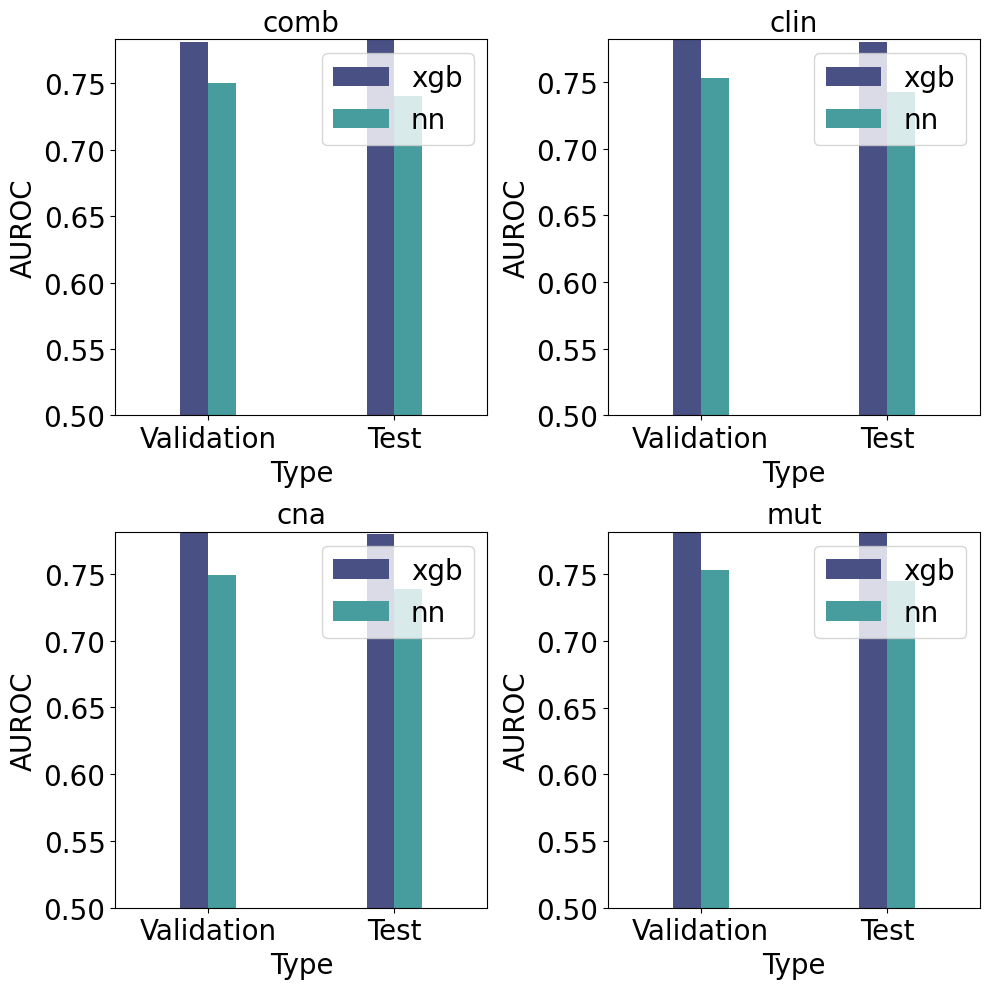

In [17]:
#plot the 4 data types in a 2x2 grid

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, data_type in enumerate(['comb', 'clin', 'cna', 'mut']):
    res_data = res_dfs['folfox_OS'][res_dfs['folfox_PFS']['data_type'] == data_type]
    res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
    ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
    res_data.columns = ['Model', 'Validation', 'Test']
    res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
    #make the size of the bars narrower
    ax = ax.flatten()
    #plot the bars, with error bars for val_auroc_mean from val_auroc_ci and test_auroc_mean from test_auroc_ci
    sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
    
    ax[i].set_title(f'{data_type}')
    ax[i].set_ylim(0.5, ymax)
    #make the font bigger
    for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
            item.set_fontsize(20)
    ax[i].legend(fontsize=20)
plt.tight_layout()
plt.show()


ValueError: min() arg is an empty sequence

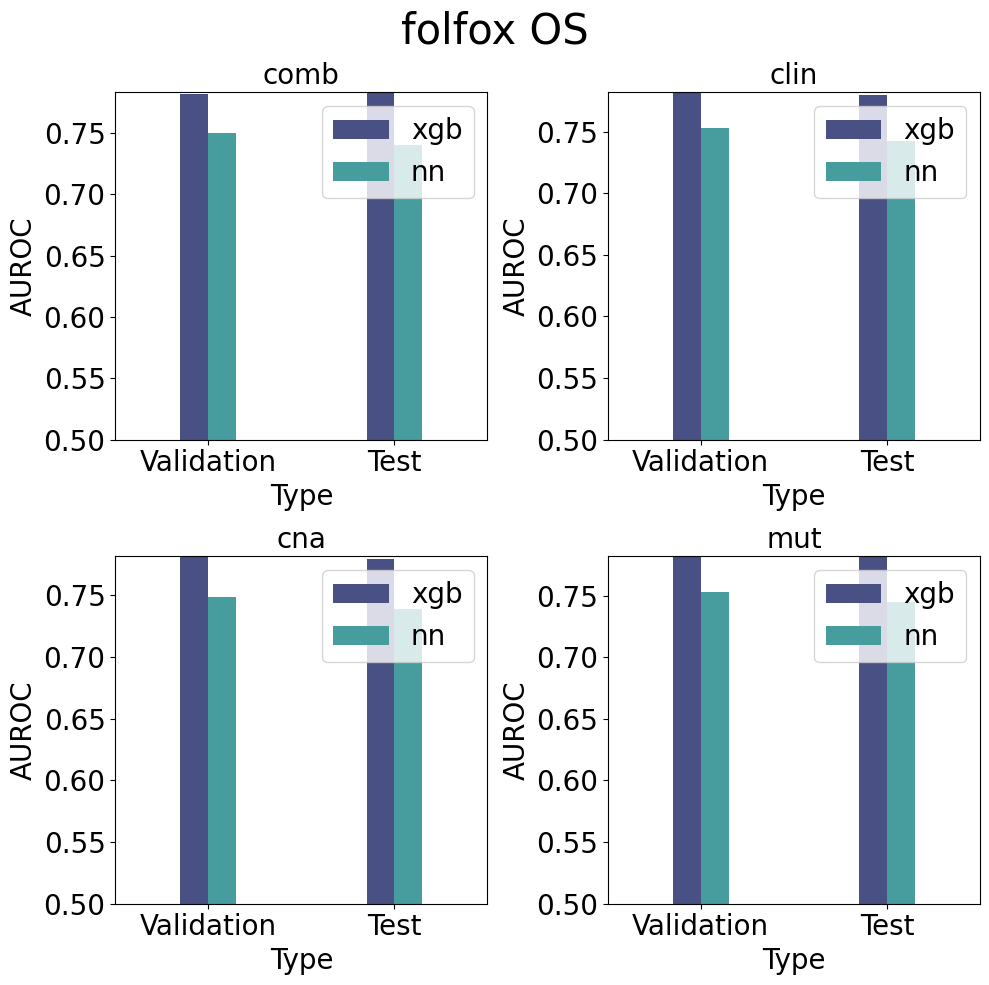

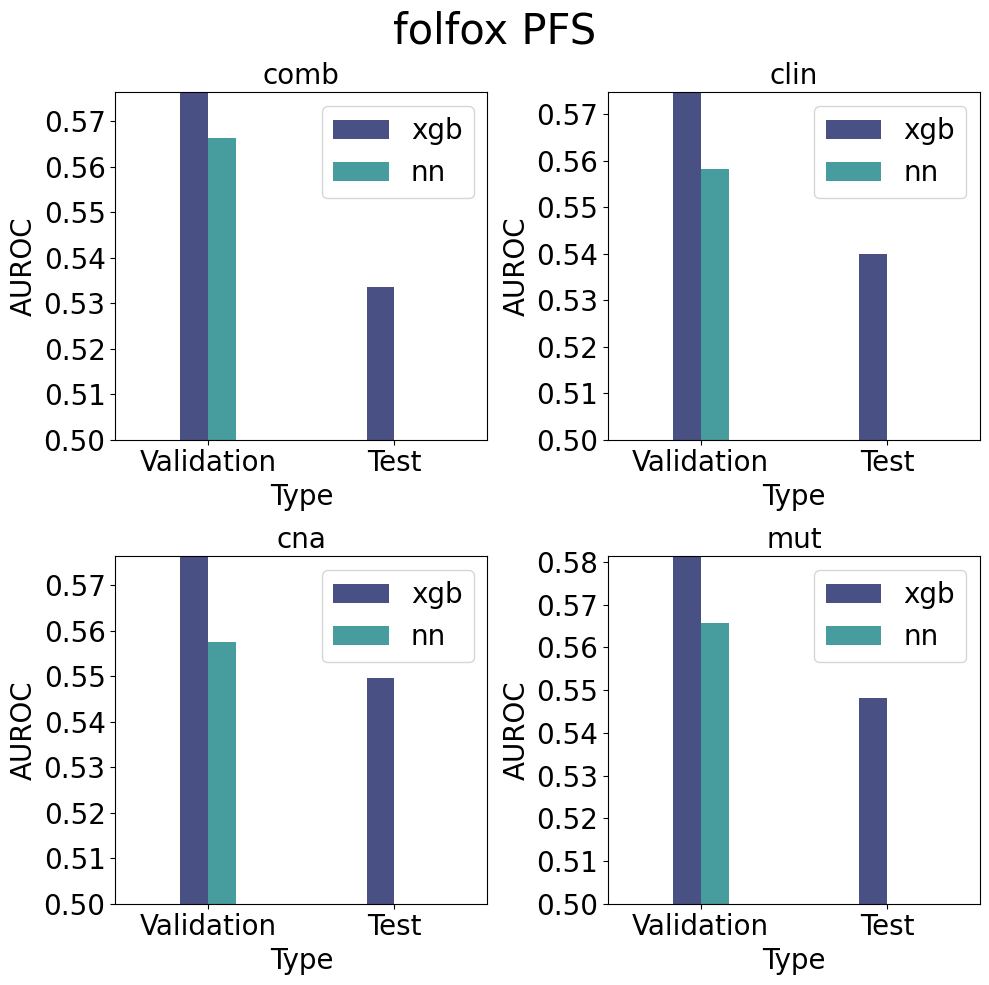

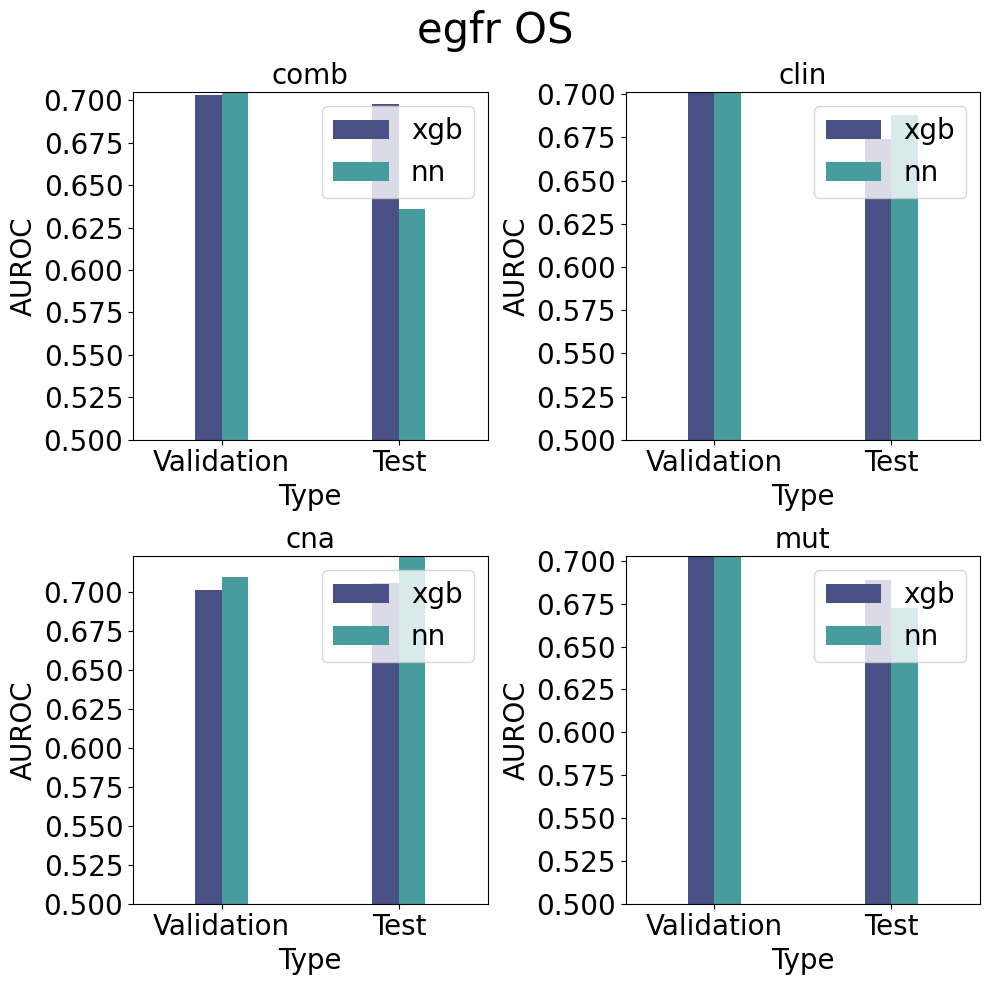

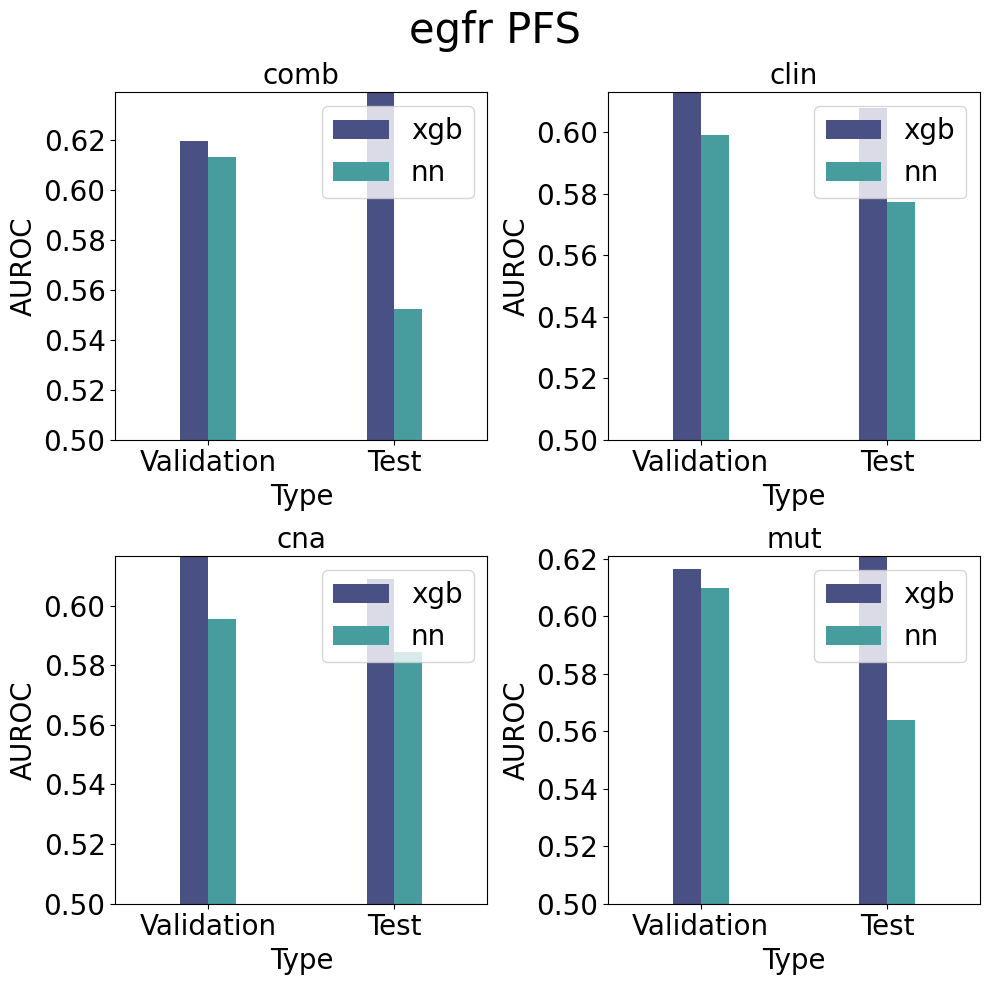

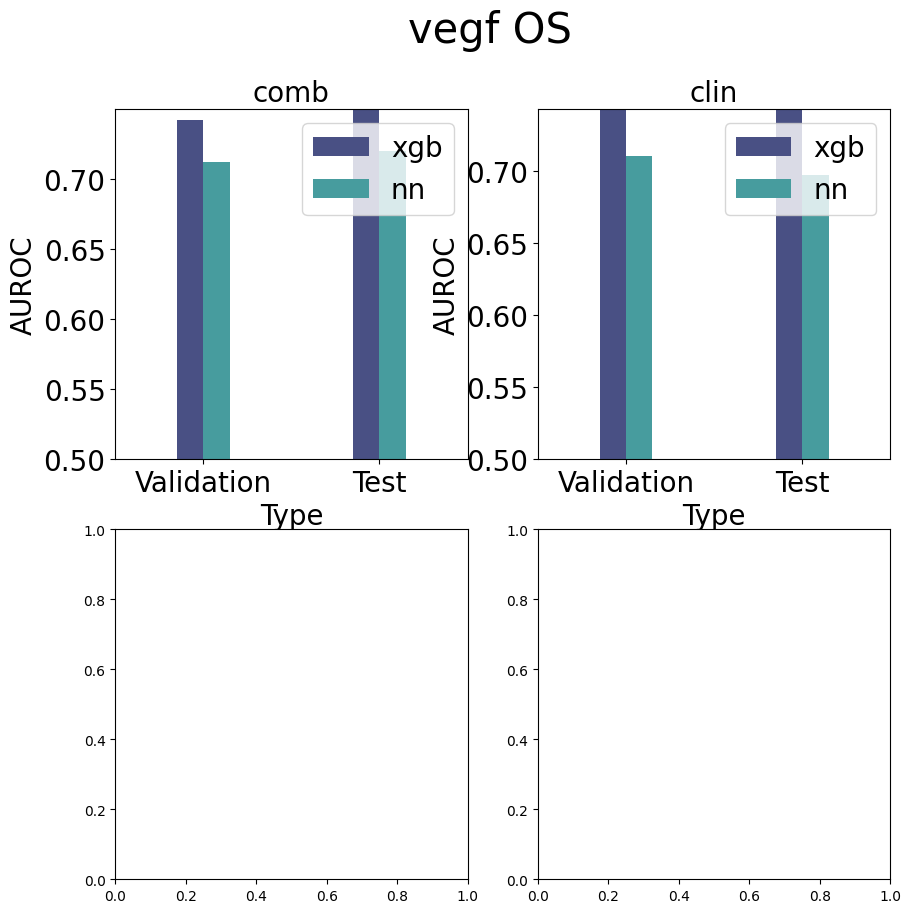

In [18]:
for drug in drugs:
        for outcome in outcomes:
                
                fig, ax = plt.subplots(2, 2, figsize=(10, 10))
                for i, data_type in enumerate(['comb', 'clin', 'cna', 'mut']):
                        res_data = res_dfs[f'{drug}_{outcome}'][res_dfs[f'{drug}_{outcome}']['data_type'] == data_type]
                        res_data = res_data[['model', 'val_auroc_mean', 'test_auroc_mean']]
                        ymax = max(res_data['val_auroc_mean'].max(), res_data['test_auroc_mean'].max())
                        res_data.columns = ['Model', 'Validation', 'Test']
                        res_data = res_data.melt(id_vars='Model', var_name='Type', value_name='AUROC')
                        #make the size of the bars narrower
                        ax = ax.flatten()
                        #plot the bars, with error bars for val_auroc_mean from val_auroc_ci and test_auroc_mean from test_auroc_ci
                        sns.barplot(x='Type', y='AUROC', hue='Model', data=res_data, errorbar=None, ax=ax[i], palette='mako', width=0.3)
                        
                        ax[i].set_title(f'{data_type}')
                        ax[i].set_ylim(0.5, ymax)
                        #make the font bigger
                        for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] + ax[i].get_xticklabels() + ax[i].get_yticklabels()):
                                item.set_fontsize(20)
                        ax[i].legend(fontsize=20)
                        fig.suptitle(f'{drug} {outcome}', fontsize=30)
                plt.tight_layout()
                plt.savefig(f'../results/runs/{today_str}/plots/{drug}_{outcome}_auroc.png')